# data transformation plan

## import & load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import statsmodels.api as sm
from tabulate import tabulate
import warnings

from sklearn.impute import KNNImputer

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None) 
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 200)

base_path = '../../data/'

In [2]:
def na_check(df, threshold = -1): 
    na = df.isna().mean()*100
    return na[na > threshold]

In [4]:
opp = pd.read_excel(f'{base_path}Copy of Ricoh_Opps_08022024.xlsx')
opm = pd.read_csv(f'{base_path}Copy of Opp_Product_Mapping_08022024.csv')
iwp = pd.read_csv(f'{base_path}Copy of Identified_Web_Pagviews_08022024.csv')
opp.columns = opp.columns.str.lower()
opm.columns = opm.columns.str.lower()
iwp.columns = iwp.columns.str.lower()

## Ricoh Opps

In [5]:
eng_cols = opp.columns[44:53].tolist()
sat_cols = opp.columns[67:69].tolist()
key_cols = ['key', 'opportunity_number', 'lead_number', 'quote_number', 'order_number', 'l2_rise_number']
inv_cols = opp.columns[53:67].tolist()
flag_cols = [col for col in opp.columns if "flag" in col]
rev_cols = [col for col in opp.columns if 'rev' in col]
dt_cols = [col for col in opp.columns if 'date' in col]

In [6]:
# Before split to lead & opp cats

# 1. filter based on problem of interest

# remove missing l2 - remove for general purpose
opp = opp[opp.l2_rise_number.notnull()]

# closed deals for now
opp = opp[opp.closed == 1].drop(['closed'], axis = 1)

# 2. type conversion

opp['quote_number'] = opp['quote_number'].apply(lambda x: str(int(x)) if pd.notna(x) else np.nan)
opp['order_number'] = opp['order_number'].apply(lambda x: str(int(x)) if pd.notna(x) else np.nan)

for col_name in dt_cols: 
    opp[col_name] = pd.to_datetime(opp[col_name])

# drop some columns 
# opp.drop(columns = ['sat', 'nps'], inplace = True)

# 3. clean up string col format

# Remove trailing white spaces for char cols (department has trailing white spaces, so just clean all) 
num_cols = opp.select_dtypes(include=['number']).columns
cat_cols = opp.select_dtypes(include=['object']).columns
opp[cat_cols] = opp[cat_cols].apply(lambda x: x.str.rstrip())

# 4. fix NAs not effected by lead/opp type
# treat missing quote and order revenues as 0, probably is actual 0.
opp['quote_rev'].fillna(0, inplace = True)
opp['order_rev'].fillna(0, inplace = True)

# 5.
# add a opportunity ind
opp['has_opp'] = opp['opportunity_number'].notna().astype(int)

In [7]:
oppo = opp[opp.has_opp == 1]
lead = opp[opp.has_opp == 0]

### opportunity

#### clean - drop lead-related cols

In [8]:
lead_cols = [col for col in oppo.columns if "lead" in col]
lead_cols.remove('lead')
oppo.drop(columns = lead_cols, inplace = True)

#### tests - skip

(array([6.7269e+04, 1.5620e+03, 1.3100e+03, 8.8900e+02, 1.7000e+02,
        1.2490e+03, 1.8300e+02, 2.8000e+01, 1.5000e+01, 1.9960e+03]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

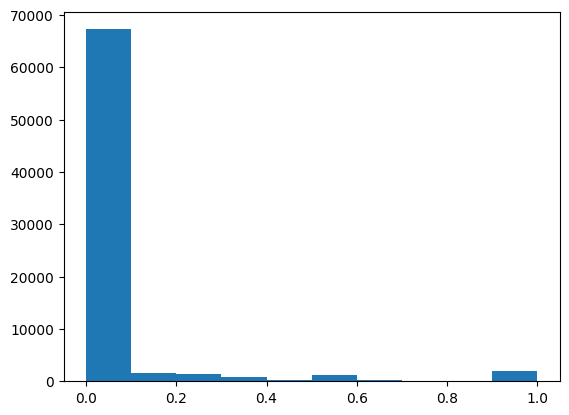

In [9]:
# check if there's a pattern in engage cols NA
engna = oppo[oppo.eloqua.isnull()]
engna_l2 = oppo.groupby('l2_rise_number').agg(engna_perc =('eloqua', lambda x: x.isnull().mean()), count = ('eloqua', 'size')).sort_values(by = 'engna_perc', ascending = False)
plt.hist(engna_l2.engna_perc) # so mostly are partial missing, than check dates

In [10]:
eng = oppo[oppo.eloqua.notnull()]
engna_open = engna.groupby('l2_rise_number').open_days.mean().reset_index()
eng_open = eng.groupby('l2_rise_number').open_days.mean().reset_index()

(array([1.000e+00, 4.290e+02, 7.660e+02, 1.357e+03, 2.301e+03, 1.727e+03,
        6.340e+02, 2.880e+02, 2.530e+02, 5.000e+00]),
 array([-274.  ,  -27.15,  219.7 ,  466.55,  713.4 ,  960.25, 1207.1 ,
        1453.95, 1700.8 , 1947.65, 2194.5 ]),
 <BarContainer object of 10 artists>)

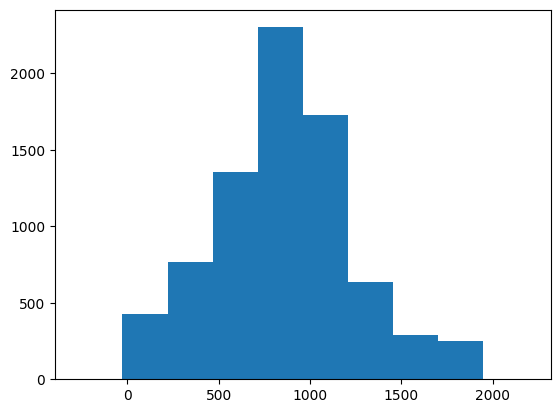

In [11]:
days = eng_open.merge(engna_open, how = 'inner', on = 'l2_rise_number', suffixes = ('_ex', '_na'))
days['diff'] = days.open_days_na - days.open_days_ex
plt.hist(days['diff']) # so probably because it happened at the very beginning so just impute with 0 then

In [12]:
dnb = oppo.groupby('l2_rise_number').agg(sum_order = ('eloqua', 'sum'), sales_dnb = ('employees_dnb', 'mean')).reset_index()
dnb.iloc[:, 1:].corr()

,sum_order,sales_dnb
sum_order,1.00000,0.58291
sales_dnb,0.58291,1.00000


In [13]:
df = oppo[['key', 'l2_rise_number', 'start_date', 'close_date', 'open_days', 'close_days']]
df['dt_diff'] = (df['close_date'] - df['start_date']).dt.days
df['dt_match'] = np.where(df.dt_diff == df.close_days, 1, 0)
df.dt_match.value_counts()

dt_match
1    615994
0        12
Name: count, dtype: int64

#### clean - fill NA

In [14]:
cat_cols = oppo.select_dtypes(include=['object']).columns
cat_sub = list(set(cat_cols) - set(key_cols))

for col in cat_sub:
    oppo[col] = oppo[col].fillna("Unknown")
    
for col in eng_cols:
    oppo[col] = oppo[col].fillna(0)

# impute inv to 0; checked if order_date na, no inv anyways
for col in inv_cols:
    oppo[col] = oppo[col].fillna(0)

# impute dnb to median, suppose to use knn (has a decent cor with max eloqua, but it took too long)
oppo['employees_dnb'].fillna(oppo['employees_dnb'].median(), inplace=True)
oppo['sales_dnb'].fillna(oppo['sales_dnb'].median(), inplace=True)

# impute days to median, compute close_date using that way
oppo['close_days'].fillna(oppo['close_days'].median(), inplace=True)
oppo['opp_rev'].fillna(oppo['opp_rev'].median(), inplace=True)

# compute missing close_dates using start_date and the imputed close_days
for index, row in oppo.iterrows():
    if pd.isna(row['close_date']) and not pd.isna(row['start_date']):
        oppo.at[index, 'close_date'] = pd.to_datetime(row['start_date']) + pd.Timedelta(days=row['close_days'])

In [15]:
na_check(oppo, 0)

quote_number    29.477635
order_number    53.153378
quote_date      29.477635
order_date      77.588368
sat             84.738623
nps             84.738623
dtype: float64

In [18]:
# save now
oppo.drop(columns = ['has_opp'], inplace = True)
oppo.to_csv(f'{base_path}/oppo.csv', index = False)

### lead


In [17]:
lead = lead.dropna(axis='columns', how='all')

In [18]:
# treat unknown for cats, leave out keys
cat_cols = lead.select_dtypes(include=['object']).columns
cat_sub = list(set(cat_cols) - set(key_cols))

for col in cat_sub:
    lead[col] = lead[col].fillna("Unknown")

for col in eng_cols:
    lead[col] = lead[col].fillna(0)

# impute inv to 0; checked if order_date na, no inv anyways
for col in inv_cols:
    lead[col] = lead[col].fillna(0)

for col in ['employees_dnb', 'sales_dnb']:
    lead[col] = lead[col].fillna(lead[col].median())

In [19]:
na_check(lead, 0)

sat    89.965194
nps    89.965194
dtype: float64

In [22]:
lead.drop(columns = ['has_opp'], inplace = True)
lead.to_csv('data/lead.csv', index = False)

## iwp & opm

### tests

In [25]:
# a lot of misisng edp bcs prob they don't have one (missing for all occurrences of certain pillars)
opm[opm.edp_code.isnull()].groupby('pillar').size().sort_values(ascending = False).head(5)

pillar
CUSTOM.ITS.HARDWARE                  19695
CUSTOM.ITS.PROSERV                   13308
CUSTOM.ITS.MRR                       11475
CUSTOM.ITS.SOFTWARE SUPPORT MAINT     9873
HARDWARE REFINANCE ONLY               8476
dtype: int64

In [26]:
# example 
opm[opm.pillar == 'HARDWARE REFINANCE ONLY'].isna().mean()

edp_code              1.000000
pillar                0.000000
category              0.000000
offering              0.000000
family                0.000000
description           0.000000
lead_number           0.996933
opportunity_number    0.000000
quantity              0.000000
match                 0.000000
dtype: float64

In [33]:
iwp['month'] = pd.to_datetime(iwp['date']).dt.to_period('M')
na_month = iwp.groupby('month').page.apply(lambda x: x.isna().mean()).sort_index()
occ_month = iwp.month.value_counts(normalize=True).sort_index()

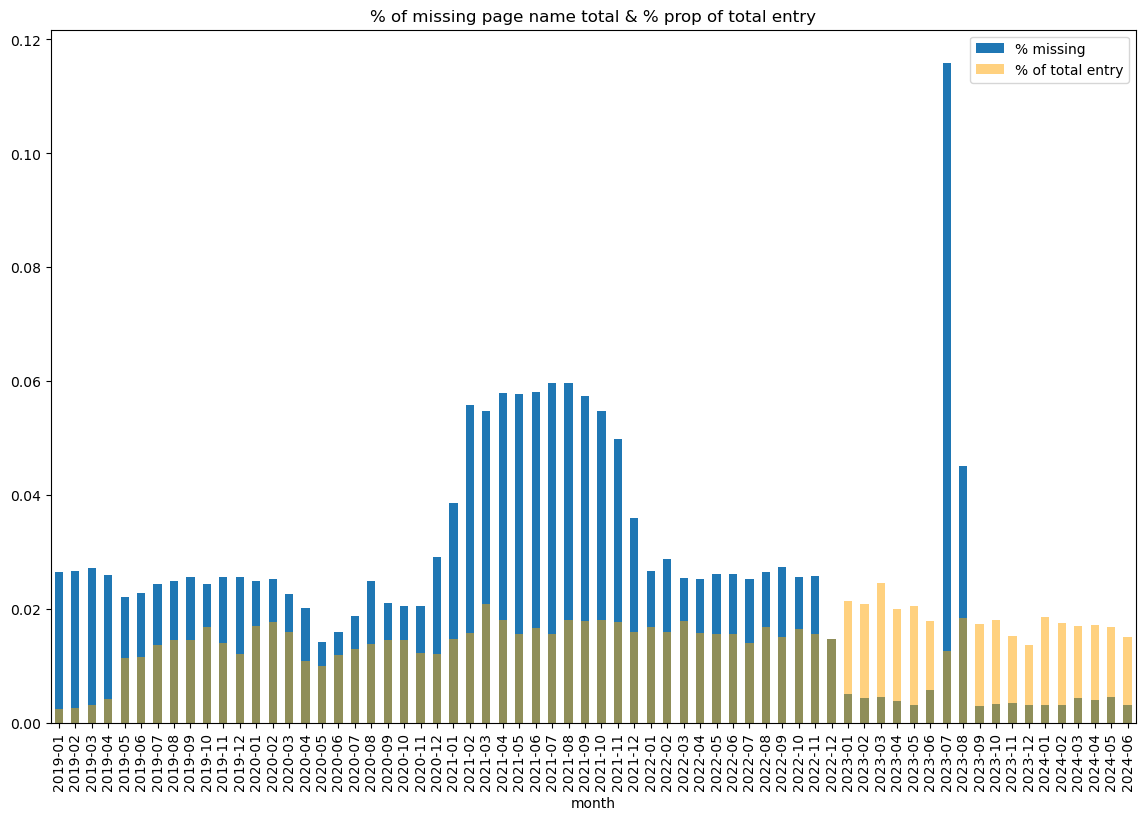

In [34]:
plt.figure(figsize = (14, 9))
na_month.plot(kind = 'bar', label = '% missing') # 2023-7? 
occ_month.plot(kind = 'bar', alpha = 0.5, color = 'orange', label = '% of total entry')
plt.title('% of missing page name total & % prop of total entry')
plt.legend()
plt.show()

### clean

In [28]:
# drop if all these are missing
descr = ['edp_code', 'pillar', 'category', 'offering', 'family', 'description', 'quantity']
opm = opm.dropna(subset = descr, how = 'all')

# prepare key match with opps
opm['key'] = opm['lead_number'].fillna(opm['opportunity_number'])
opm['quantity'].fillna(1, inplace = True)

na_check(opm, 0)

opm.to_csv(f'{base_path}opm.csv', index = False) 

In [23]:
iwp = iwp[iwp.page.notnull()]
na_check(iwp, 0)
iwp.to_csv(f'{base_path}iwp.csv', index = False)